In [1]:
import adddeps
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from scipy.stats import norm,normaltest, probplot

import pandas as pd
import sqlalchemy
from collections import defaultdict
# from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, IntSlider
import datetime
import importlib
from simulator import SimulatorMagnetic, SimulatorLennard
from simulator.models import Client, SimulationAlchemy as Simulation
from tqdm import tqdm

import multiprocessing
from multiprocessing import Pool, cpu_count

import logging.config
import logging
import sys, os
matplotlib.rcParams["figure.dpi"] = 150
client = Client()

In [2]:
def standartize(arr):
    return (arr - np.mean(arr))/np.std(arr)

In [3]:
with client.Session() as session:
    query = (session.query(Simulation.id)
                 .where(Simulation.group_name=='Ensemble 5.1.lammps')
                 .order_by(Simulation.start_time)).all()[:]
query = [x[0] for x in query]
print(len(query))

10176


In [25]:
def f(sid):
    item = client.query_simulation(id=sid)
    
    sim = SimulatorLennard(item=item)
    dfs = sim.get_data_frames()
    
    TE = (dfs["KE"] + dfs["PE"] + 0.5*dfs["IE"]).sum(axis=1)

    if np.max(np.abs(TE-TE[0]))/TE[0] > 0.5:
        return None
    
    start = np.searchsorted(sim.get_history()["time"], 40)
    rs = sim.get_history()["rs"][start:].transpose(0,2,1).reshape(-1,3).T
    vs = sim.get_history()["vs"][start:].transpose(0,2,1).reshape(-1,3).T
    
    omega_MLE = np.mean(rs[0]*vs[1]-rs[1]*vs[0])/np.mean(rs[0]**2+rs[1]**2)
    beta_MLE  = (1/3 * np.mean( (vs[0]+omega_MLE * rs[1])**2 + (vs[1]-omega_MLE * rs[0])**2 + (vs[2])**2) )**-1
    
    return {"omega_MLE" : omega_MLE,
            "beta_MLE" : beta_MLE,
            "N" : sim.particle_number(),
            "L" : sim.angular_momentum(sim.r_init, sim.v_init)[2].sum(),
            "E" : sim.total_energy(sim.r_init, sim.v_init),
            "E_end" : sim.total_energy(sim.get_history()["rs"][-1], sim.get_history()["vs"][-1]),
            "alpha" : sim.abc[0]**-1
           }

In [26]:
if "pool" in dir():
    pool.close()
    print("closed")
pool = Pool(cpu_count()-5, maxtasksperchild=1); pool

In [7]:
np.random.shuffle(query)

In [27]:
f(query[0])

{'omega_MLE': 0.4318508125439115,
 'beta_MLE': 0.4769132251391517,
 'N': 115,
 'L': 253.41205314192425,
 'E': 836.0577875672627,
 'E_end': 830.0792563825398,
 'alpha': 1.0}

In [ ]:
retult = list(tqdm(pool.imap(f, query[:]), total=len(query)))

  0%|          | 0/10176 [00:00<?, ?it/s]

In [28]:
retult = [f(x) for x in tqdm(query[:])]

100%|██████████| 10176/10176 [6:39:26<00:00,  2.36s/it]  


In [16]:
result = [x for x in retult if x is not None]
len(result)

10176

In [17]:
df = pd.DataFrame(result)

In [18]:
df["x"] = df.alpha * df.L / df.E
df["y_beta"] = 3 * df.N/df.E/df.beta_MLE
df["y_omega"] = df.omega_MLE * df.L / df.E

In [19]:
def f_beta(x):
    return 3 * (1 - x**2)/(2 + np.sqrt(1 + 3 * x**2))
def f_omega(x):
    return np.sqrt(1 + 3 * x**2) - 1

In [20]:
df[["x","y_beta","y_omega"]].to_csv("beta-omega-plot-data-ensemble-5.1.csv", index=False)

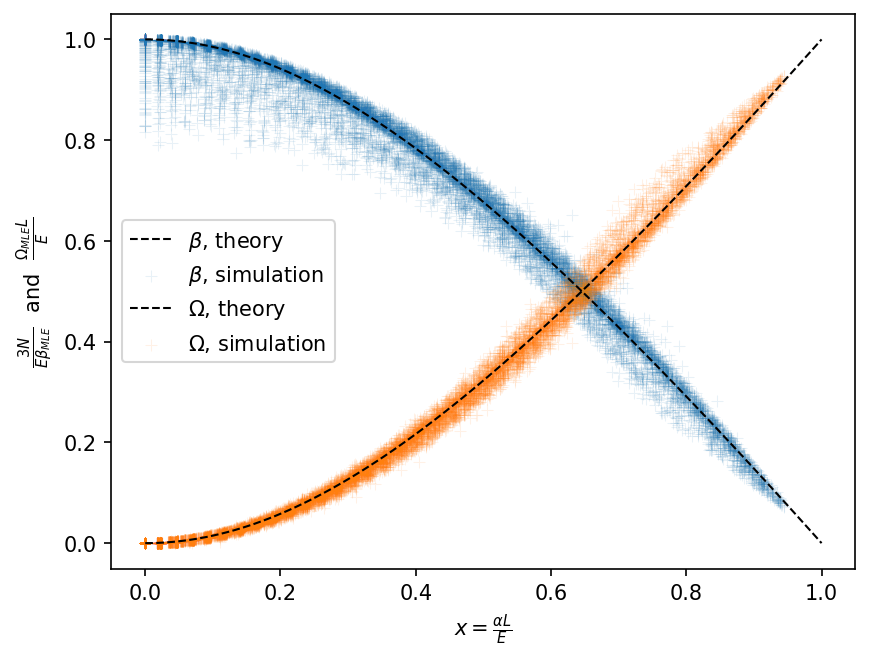

In [21]:
xs = np.linspace(0,1,100)
alpha=0.1
plt.plot(xs, f_beta(xs), "k--", lw=1, label=r"$\beta$, theory")
plt.scatter(df["x"], df["y_beta"], marker="+", s=30,lw=0.5, alpha=alpha, label=r"$\beta$, simulation")

plt.plot(xs, f_omega(xs), "k--", lw=1, label="$\Omega$, theory")
plt.scatter(df["x"], df["y_omega"], marker="+", s=30,lw=0.5, alpha=alpha, label=r"$\Omega$, simulation")


plt.xlabel(r"$x=\frac{\alpha L}{E}$")

plt.ylabel(r"$\frac{3 N}{ E \beta_{MLE} }$  and  $\frac{\Omega_{MLE} L}{E}$")
plt.legend()

In [14]:
with client.Session() as session:
    query = (session.query(Simulation.id)
                 .where(Simulation.group_name=='Ensemble 4')
                 .where(Simulation.Bz == 0)
                 .order_by(Simulation.start_time)).all()[:]
query = [x[0] for x in query]
print(len(query))

1001


In [15]:
np.random.shuffle(query)

In [17]:
sims = []
for sid in tqdm(query[:200]):
    sims.append(
        SimulatorMagnetic(id=sid)
    )

100%|██████████| 200/200 [03:32<00:00,  1.06s/it]


In [18]:
from relaxation.estimators import RelaxationFinder

In [ ]:
RelaxationFinder(sim, tmax=50)

In [ ]:
_74.summarize()

In [20]:
data = []
rs = []
vs = []
for sim in tqdm(sims):
    start = np.searchsorted(sim.get_history()["time"], 40)
    rs.append(sim.get_history()["rs"][start:].transpose(0,2,1).reshape(-1,3))
    vs.append(sim.get_history()["vs"][start:].transpose(0,2,1).reshape(-1,3))
rs = np.concatenate(rs).T
vs = np.concatenate(vs).T

100%|██████████| 200/200 [00:06<00:00, 33.08it/s]


In [21]:
omega_MLE = np.mean(rs[0]*vs[1]-rs[1]*vs[0])/np.mean(rs[0]**2+rs[1]**2)
beta_MLE  = (1/3 * np.mean( (vs[0]+omega_MLE * rs[1])**2 + (vs[1]-omega_MLE * rs[0])**2 + (vs[2])**2) )**-1

In [22]:
omega_MLE, beta_MLE

(0.7211721, 5.182699145361456)

In [23]:
residue = beta_MLE**0.5 * np.array([
    vs[0] + omega_MLE * rs[1],
    vs[1] - omega_MLE * rs[0],
    vs[2]
])

NormaltestResult(statistic=654.0693174267558, pvalue=9.346571436511023e-143)

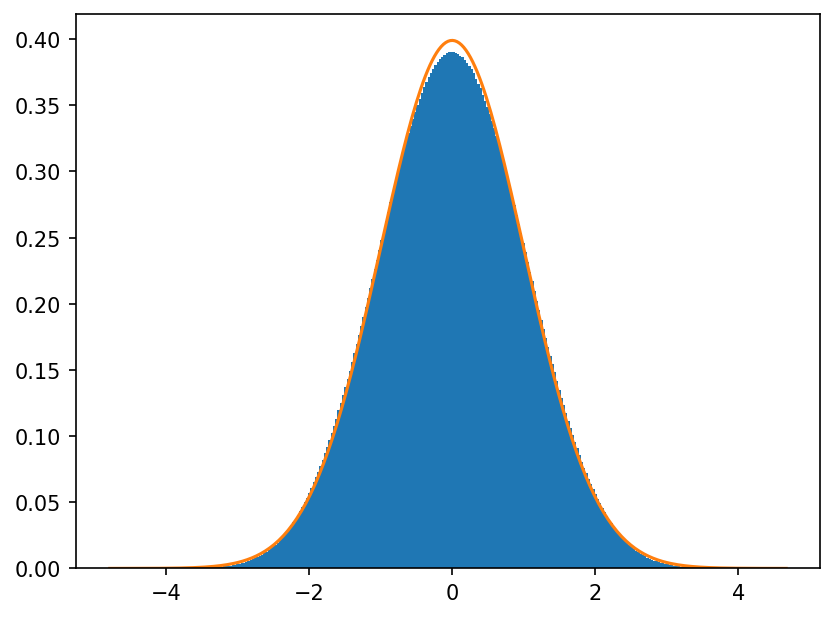

In [24]:
points = standartize(vs[0])
_,xs,_ = plt.hist(points, bins=300, density=1)
plt.plot(xs, norm.pdf(xs, loc=0, scale=1))
normaltest(residue[0])

In [27]:
points.shape

(197780600,)

In [31]:
%%time
((osm, osr), (slope, intercept, _r)) = probplot(points[::100], dist="norm",)

CPU times: user 271 ms, sys: 35.4 ms, total: 307 ms
Wall time: 302 ms


In [53]:
# plot_data = (
#     [standartize(vs[0]), standartize(vs[2]), standartize(rs[0]), standartize(rs[2]), residue[0], residue[1], residue[2]],
#     ["$v_x$", "$v_z$", "$r_x$", "$r_z$", "residue${}_x$", "residue${}_y$", "residue${}_z$"]
# )

N_ = 10**7

plot_data = (
    [np.random.choice(x, N_, replace=False) for x in 
     [standartize(vs[0]), standartize(rs[0]), residue[0]]],
    ["$v_x$", "$r_x$","residue${}_x$"]
)

In [52]:
import pickle
with open("QQ-data.pkl", "wb") as f:
    pickle.dump(plot_data, f)

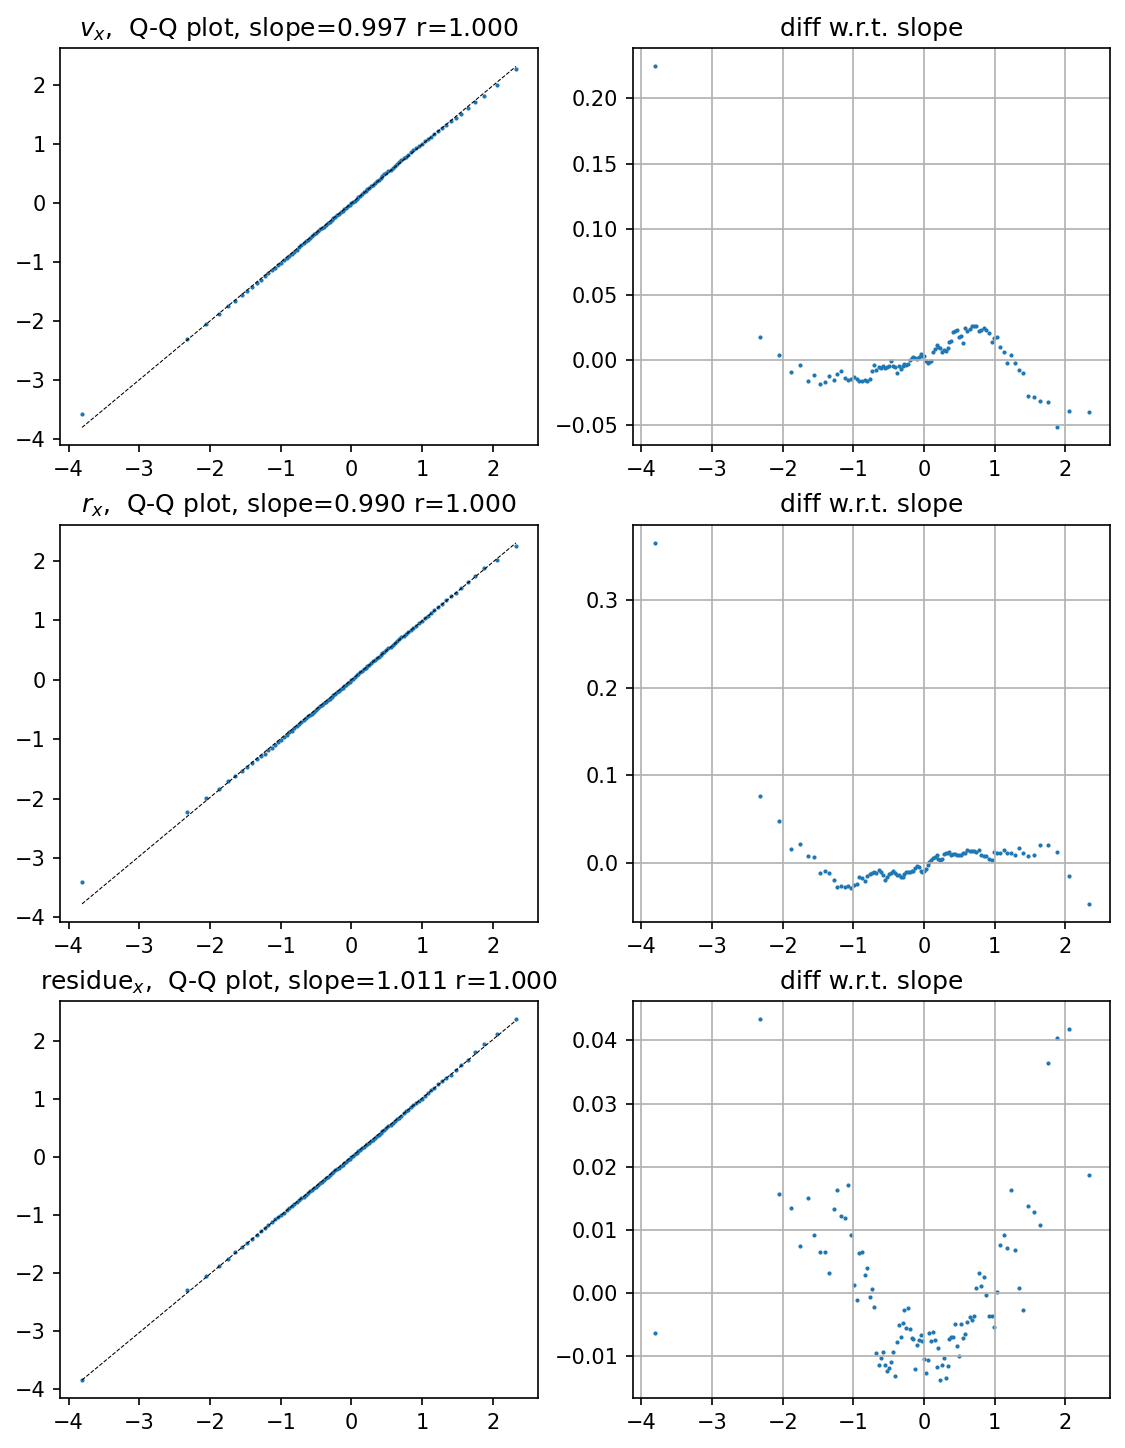

In [50]:
sp=100
n_ = len(plot_data[0])
i_ = 1
plt.figure(figsize=(8,3 * n_))
for points, title in zip(*plot_data): 
    
    ((osm, osr), (slope, intercept, _r)) = probplot(points, dist="norm",)
    
    plt.subplot(n_, 2, i_);i_+=1
    plt.scatter(osm[::sp], osr[::sp], s=1)
    plt.plot(osm[::sp], osm[::sp] * slope + intercept, ls="--", c="k", lw=0.51)
    plt.title(title+",  "+f"Q-Q plot, slope={slope:0.3f} r={_r:0.3f}");
        
    plt.subplot(n_, 2, i_);i_+=1
    plt.title("diff w.r.t. slope")
    plt.scatter(osm[::sp], osr[::sp]-(osm[::sp] * slope + intercept), s=1)
    plt.grid()

plt.subplots_adjust(bottom=0, right=1, top=1)